## Constant expected return model

We are assuming the CER model. This is a standard model in finance, which assumes that the expected return of an asset is constant over time.

Assume we have $n$ assets with returns $\{R_i\}_{i=1}^n$ that we want to invest in, where each $R_i$ is a random variable representing the return of asset $i$. The expected return of asset $i$ is denoted as $\mu_i = \mathbb{E}[R_i]$, and the covariance between the returns of assets $i$ and $j$ is denoted as $\Sigma_{ij} = \text{Cov}(R_i, R_j)$.

Suppose we have a total amount to invest, and we wish to split this amount among the $n$ assets. Let $w_i$ be the fraction of the total amount invested in asset $i$, such that $\sum_{i=1}^n w_i = 1$. The return for our portfolio can be expressed as:

$$
R_p = \sum_{i=1}^n w_i R_i
$$

and the expected return of the portfolio is given by:

$$
\mathbb{E}[R_p] = \sum_{i=1}^n w_i \mu_i = \overline{\mu}^T \overline{w} = \overline{w}^T \overline{\mu}
$$

The variance of the portfolio return is given by:
$$
\text{Var}(R_p) = \overline{w}^T \Sigma \overline{w} = \sum_{i=1}^n \sum_{j=1}^n w_i w_j \Sigma_{ij}
$$

### Minimizing the variance

Our goal is to find the weights $w_i$ that minimize the variance of the portfolio return, subject to the constraint that the weights sum to 1. This can be formulated as a constrained optimization problem:

$$
\min_{\overline{w} \in \mathbb{R}^n} \overline{w}^T \Sigma \overline{w} \quad \text{subject to} \quad \|{\overline{w}}\|_1 = 1
$$

We define the Lagrangian for this problem as:

$$
\mathcal{L}(\overline{w}, \lambda) = \overline{w}^T \Sigma \overline{w} - \lambda (\sum_{i=1}^n w_i-1)
$$

and solve the system $\nabla_{\overline{w}} \mathcal{L} = 0$ which is:
$$
2\Sigma \overline{w} - \lambda \mathbf{1} = 0.
$$

This finally gives us the KKT conditions:

\begin{aligned}
2\Sigma \overline{w} &= \lambda \mathbf{1}\\
\|{\overline{w}}\|_1 &= 1
\end{aligned}

which can be written as the matrix equation:

$$

\begin{pmatrix}
2\Sigma & \mathbf{1} \\
\mathbf{1}^T & 0
\end{pmatrix}
\begin{pmatrix}
\overline{w} \\
\lambda
\end{pmatrix}
=
\begin{pmatrix}
0 \\
1
\end{pmatrix}.
$$

This gives the optimal solution

$$
\begin{pmatrix}
\overline{w} \\
\lambda
\end{pmatrix}
= 
\begin{pmatrix}
2\Sigma & \mathbf{1} \\
\mathbf{1}^T & 0
\end{pmatrix}^{-1}
\begin{pmatrix}
0 \\
1
\end{pmatrix}.
$$

In real financial markets, asset returns are rarely, if ever, perfectly correlated. Therefore, the covariance matrix $\Sigma$ is typically positive definite, and the KKT matrix is invertible. However, due to near-collinearity between some assets or limited data, $\Sigma$ can be ill-conditioned in practice, even if it is not exactly singular. In such cases, regularization or the Moore–Penrose pseudoinverse may be used to ensure a stable solution.


In [12]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [13]:
def compute_min_variance_weights(Sigma: np.ndarray) -> np.ndarray:
    """
    Compute the minimum-variance portfolio weights given a covariance matrix Sigma.
    
    Parameters:
        Sigma (np.ndarray): Covariance matrix of shape (n, n)
    
    Returns:
        np.ndarray: Optimal weights vector of shape (n,)
    """
    cond_threshold = 1e10
    n = Sigma.shape[0]
    ones = np.ones((n, 1))
    

    # Construct the KKT matrix
    top = np.hstack((2 * Sigma, ones))
    bottom = np.hstack((ones.T, np.array([[0]])))
    KKT = np.vstack((top, bottom))

    # Right-hand side
    rhs = np.vstack((np.zeros((n, 1)), np.array([[1]])))

    # Solve the system
    try:
        if np.linalg.cond(KKT) > cond_threshold:
            print("Matrix is ill-conditioned, using pseudoinverse.")
            solution = np.linalg.pinv(KKT) @ rhs
        else:
            solution = np.linalg.solve(KKT, rhs)
    except np.linalg.LinAlgError:
        print("Matrix is singular, using pseudoinverse.")
        solution = np.linalg.pinv(KKT) @ rhs

    weights = solution[:n].flatten()
    w = weights.reshape(-1, 1)
    risk = np.sqrt((w.T @ Sigma @ w)[0, 0])
    return weights, risk

# Example usage
Sigma = np.array([[0.0110, 0.0015, 0.0008], [0.0015, 0.0121, 0.0016], [0.0008, 0.0016, 0.0218]])

weights, risk = compute_min_variance_weights(Sigma)
print("Minimum-variance portfolio weights:", weights)
print("Portfolio risk:", risk)




Minimum-variance portfolio weights: [0.42707714 0.36723413 0.20568873]
Portfolio risk: 0.0735747964764058


### Minimum variance portfolio with specified expected return
In some cases, we may want to find the minimum variance portfolio that achieves a specified expected return $\mu^*$. This can be formulated as:
$$
\min_{\overline{w} \in \mathbb{R}^n} \overline{w}^T \Sigma \overline{w} \quad \text{subject to} \quad \overline{w}^T \overline{\mu} = \mu^* \quad \text{and} \quad \|{\overline{w}}\|_1 = 1.
$$
We can again use the Lagrangian method to solve this problem. The Lagrangian is given by:
$$
\mathcal{L}(\overline{w}, \lambda, \gamma) = \overline{w}^T \Sigma \overline{w} - \lambda (\overline{w}^T \overline{\mu} - \mu^*) - \gamma (\sum_{i=1}^n w_i - 1).
$$

Taking the gradient with respect to $\overline{w}$ and setting it to zero gives us the KKT conditions:
\begin{aligned}
2\Sigma \overline{w} &= \lambda \overline{\mu} + \gamma \mathbf{1}\\
\|{\overline{w}}\|_1 &= 1\\
\overline{w}^T \overline{\mu} &= \mu^*.
\end{aligned}
This can be expressed in matrix form as:
$$
\begin{pmatrix}
2\Sigma & \overline{\mu} & \mathbf{1} \\
\overline{\mu}^T & 0 & 0 \\
\mathbf{1}^T & 0 & 0
\end{pmatrix}
\begin{pmatrix}
\overline{w} \\
\lambda \\
\gamma
\end{pmatrix}
=
\begin{pmatrix}
0 \\
\mu^* \\
1
\end{pmatrix},
$$

and gives the optimal solution:

$$
\begin{pmatrix}
\overline{w} \\
\lambda \\
\gamma
\end{pmatrix}
=
\begin{pmatrix}
2\Sigma & \overline{\mu} & \mathbf{1} \\
\overline{\mu}^T & 0 & 0 \\
\mathbf{1}^T & 0 & 0
\end{pmatrix}^{-1}
\begin{pmatrix}
0 \\
\mu^* \\ 1
\end{pmatrix}.
$$



In [14]:
def compute_min_variance_weights_given_return(Sigma: np.ndarray, target_return: float, returns: np.ndarray) -> np.ndarray:
    """
    Compute the minimum-variance portfolio weights given a covariance matrix Sigma, the target return, and the expected returns of assets.
    
    Parameters:
        Sigma (np.ndarray): Covariance matrix of shape (n, n)
        target_return (float): Target return for the portfolio
        returns (np.ndarray): Expected returns of assets of shape (n,)
    
    Returns:
        np.ndarray: Optimal weights vector of shape (n,)
    """
    cond_threshold = 1e10
    n = Sigma.shape[0]
    ones = np.ones((n, 1))
    mu = returns.reshape(-1, 1)  # shape (n, 1)
    

    # Construct the KKT matrix
    top = np.hstack((2 * Sigma, mu, ones))                      # shape (n, n+2)
    middle = np.hstack((mu.T, np.array([[0, 0]])))              # shape (1, n+2)
    bottom = np.hstack((ones.T, np.array([[0, 0]])))            # shape (1, n+2)
    KKT = np.vstack((top, middle, bottom))                      # shape (n+2, n+2)


    # Right-hand side
    rhs = np.vstack((np.zeros((n, 1)), [[target_return]], [[1]]))


    # Solve the system
    try:
        if np.linalg.cond(KKT) > cond_threshold:
            print("Matrix is ill-conditioned, using pseudoinverse.")
            solution = np.linalg.pinv(KKT) @ rhs
        else:
            solution = np.linalg.solve(KKT, rhs)
    except np.linalg.LinAlgError:
        print("Matrix is singular, using pseudoinverse.")
        solution = np.linalg.pinv(KKT) @ rhs

    weights = solution[:n].flatten()
    
	# Calculate the risk
    w = weights.reshape(-1, 1)
    risk = np.sqrt((w.T @ Sigma @ w)[0, 0])
    return weights, risk

# Example usage with target return
Sigma = np.array([
    [0.0220, 0.0030, 0.0016],
    [0.0030, 0.0242, 0.0032],
    [0.0016, 0.0032, 0.0436]
])

mu = np.array([[0.0385], [0.0021], [0.0202]])  # shape (3, 1)

target_return = 0.0305

weights_with_return, risk = compute_min_variance_weights_given_return(Sigma, target_return, mu.flatten())
print("Minimum-variance portfolio weights with target return:", weights_with_return)
print("Risk of the portfolio:", risk)

Minimum-variance portfolio weights with target return: [0.67700323 0.11542316 0.20757361]
Risk of the portfolio: 0.11556902959258998


## Markowitz model using CVXPY

In [15]:
n = 3
Sigma = np.array([
    [0.0220, 0.0030, 0.0016],
    [0.0030, 0.0242, 0.0032],
    [0.0016, 0.0032, 0.0436]
])

mu = np.array([0.0385, 0.0021, 0.0202])  # shape (3, 1)

r_target = 0.0305

# Define optimization variable
w = cp.Variable(n)

# Define the objective function (minimize variance)
objective = cp.Minimize(cp.quad_form(w, Sigma))

# Define the constraints
constraints = [
	cp.sum(w) == 1,
	mu @ w >= r_target
]

problem = cp.Problem(objective, constraints)
problem.solve()

# Output results
print("Optimal weights:", w.value)
print("Expected return in %: ", mu @ w.value * 100)
print("Portfolio variance in %: ", w.value.T @ Sigma @ w.value * 100)

Optimal weights: [0.67700323 0.11542316 0.20757361]
Expected return in %:  3.0499999999999994
Portfolio variance in %:  1.335620060097294


## Efficient frontier

To visualize the efficient frontier, we solve the mean-variance problem across a range of target returns $r_{target}$. For each target, we find the portfolio that minimizes variance. The collection of these portfolios forms the efficient frontier, which illustrates the best achievable trade-offs between risk and return under the given constraints.

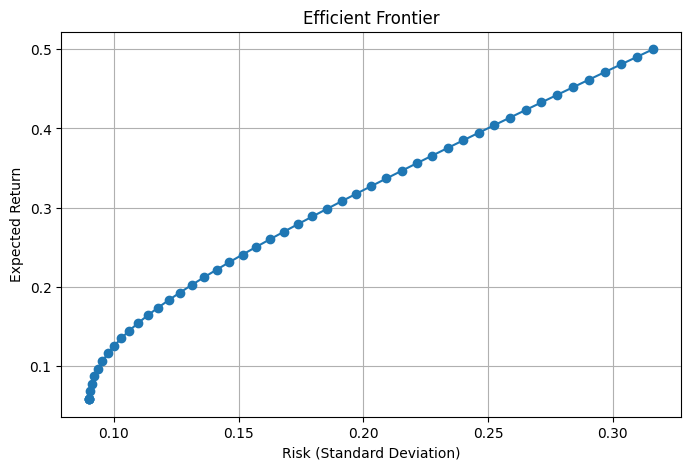

In [18]:


# Example data
n = 4
mu = np.array([0.5, 0.12, 0.07, 0.03])
Sigma = np.array([
    [0.1, 0.02, 0.04, 0.00],
    [0.02, 0.08, 0.01, 0.00],
    [0.04, 0.01, 0.09, 0.00],
    [0.00, 0.00, 0.00, 0.01]
])

# Range of target returns
r_min = mu.min()
r_max = mu.max()
r_targets = np.linspace(r_min, r_max, 50)

returns = []
risks = []

for r_target in r_targets:
    w = cp.Variable(n)
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= r_target,
        w >= 0  # No short selling
    ]
    objective = cp.Minimize(cp.quad_form(w, Sigma))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    if w.value is not None:
        port_return = mu @ w.value
        port_variance = w.value.T @ Sigma @ w.value
        returns.append(port_return)
        risks.append(np.sqrt(port_variance))
    else:
        # If problem is infeasible, skip
        continue

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(risks, returns, marker='o')
plt.xlabel("Risk (Standard Deviation)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier")
plt.grid(True)
plt.show()
